In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28)

In [4]:
net = torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [5]:
X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [6]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

In [9]:
def evaluate_accuracy_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device=next(iter(net.parameters())).device
    metric=d2l.Accumulator(2)
    
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                X=[x.to(device) for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [10]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    print('training on',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer,num_batches=d2l.Timer(),len(train_iter)
    
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)
        
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
                timer.stop()
                train_l=metric[0]/metric[2]
                train_acc=metric[1]/metric[2]
                if(i+1)%(num_batches//5)==0 or i==num_batches-1:
                    animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
                    
        test_acc=evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

loss 0.179, train acc 0.932, test acc 0.899
96467.7 examples/sec on cuda:0


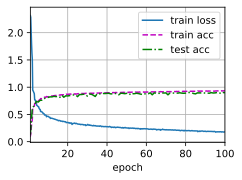

In [12]:
lr, num_epochs = 0.9, 100
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())